# Can I plot the single-cell tracks and glimpses

Using the ground-truth checked tracks from the control (3,5) example.

In [97]:
import os
import btrack
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from macrohet import dataio, tools
from tqdm.auto import tqdm
from scipy import stats
import pickle
import re
import cv2
from skimage import io
colors = sns.set_palette('PiYG')
track_scale_factor = 5.04

### Load metadata

In [230]:
base_dir = '/mnt/DATA/macrohet/'
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Load all tracks

In [231]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/21 04:36:07 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/21 04:36:07 PM] Loading tracks/obj_type_1
[INFO][2023/06/21 04:36:07 PM] Loading LBEP/obj_type_1
[INFO][2023/06/21 04:36:07 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/21 04:36:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/21 04:36:08 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:36:08 PM] Loading tracks/obj_type_1
[INFO][2023/06/21 04:36:08 PM] Loading LBEP/obj_type_1
[INFO][2023/06/21 04:36:08 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/21 04:36:09 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/21 04:36:09 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/21 04:36:09 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/21 04:36:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/21 04:36:25 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/21 04:36:25 PM] Loading tracks/obj_type_1
[INFO][2023/06/21 04:36:25 PM] Loading LBEP/obj_type_1
[INFO][2023/06/21 04:36:25 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/21 04:36:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/21 04:36:26 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 04:36:26 PM] Loading tracks/obj_type_1
[INFO][2023/06/21 04:36:26 PM] Loading LBEP/obj_type_1
[INFO][2023/06/21 04:36:26 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/21 04:36:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/21 04:36:26 PM] Opening HDF file: /mnt/DATA/macrohe

### Pick set of tracks of interest

In [4]:
row, column = 3, 5
# tracks = tracks_dict[(row, column)]

### Load ground truth labels for tracks

In [5]:
gt_track_dict_fn = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/(3, 5)_track_assessment.json'
# Load the JSON data from the file
with open(gt_track_dict_fn, 'r') as file:
    gt_track_dict = json.load(file)

In [6]:
gt_track_dict

{'425': True,
 '694': True,
 '403': False,
 '427': True,
 '453': False,
 '217': True,
 '1002': False,
 '1893': False,
 '1986': False,
 '2192': False,
 '401': True,
 '412': False,
 '2499': False,
 '1446': False,
 '1003': True,
 '790': False,
 '1552': False,
 '2862': False,
 '432': True,
 '456': True,
 '461': True,
 '416': True,
 '1892': False,
 '430': True,
 '1226': True,
 '1783': True,
 '429,2818': 'Link',
 '431': True,
 '407': True,
 '2675,404': 'Link',
 '398': True,
 '423': True,
 '424': True,
 '428': False,
 '418': False,
 '411': False,
 '411,1683': 'Link',
 '1058': False,
 '466': True,
 '465': True,
 '397': True,
 '426': True,
 '419': True,
 '1735': True,
 '420': True,
 '421': True,
 '802': True,
 '455': False,
 '406': False,
 '410': True,
 '411,1118': 'Link',
 '1118': True,
 '1114,2130': 'Link',
 '414': True,
 '459': True,
 '2234': True,
 '470': True,
 '437': True,
 '1649,2453': 'Link',
 '2453,3126': 'Link',
 '444': True,
 '865': False,
 '441': True,
 '318': False,
 '2952': False,

In [7]:
true_IDs = [int(ID) for ID, status in gt_track_dict.items() if status is True]

### Filter true tracks

In [8]:
true_tracks = [t for t in tracks if t.ID in true_IDs]

In [9]:
true_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,area,major_axis_length,Infected,orientation,minor_axis_length
0,415,0,646.399170,13.854697,0.000000,415,415,5,0,False,"(3,) array",22945.0,183.616516,0.0,-1.299407,165.773468
1,415,1,650.164307,14.070254,0.000000,415,415,5,0,False,"(3,) array",21613.0,191.323593,1.0,-0.933135,149.679901
2,415,2,646.336243,15.021686,0.000000,415,415,5,0,False,"(3,) array",32762.0,266.828552,0.0,1.217239,160.255814
3,415,3,647.075012,13.532184,0.000000,415,415,5,0,False,"(3,) array",30766.0,252.224564,1.0,1.366426,163.807724
4,415,4,643.531616,14.334802,0.000000,415,415,5,0,False,"(3,) array",35036.0,281.792450,0.0,1.383147,166.019028
5,415,5,647.164917,15.555568,0.000000,415,415,5,0,False,"(3,) array",39674.0,310.568237,0.0,1.211316,176.218536
6,415,6,646.509888,16.028267,0.000000,415,415,5,0,False,"(3,) array",46810.0,383.824982,1.0,1.228297,174.463684
7,415,7,649.420410,20.633850,0.000000,415,415,5,0,False,"(3,) array",37964.0,346.742157,0.0,1.025235,143.170151
8,415,8,649.743835,23.328390,0.000000,415,415,5,0,False,"(3,) array",35188.0,387.503235,0.0,1.090551,121.325844
9,415,9,652.271912,23.548986,0.000000,415,415,5,0,False,"(3,) array",38329.0,383.192474,1.0,1.133885,135.233444


# Load sc_df

In [10]:
# Specify the path to your pickle file
sc_df_path = "/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl"

# Load the pickle file
with open(sc_df_path, "rb") as file:
    df = pickle.load(file)

### Format df so that it can be read by Bokeh

- dont think this is strictly necessary, done automatically when passing to a ColumnDataSource

In [11]:
# Remove non-letter characters and replace spaces with underscores in column names
df.columns = [re.sub(r'[^a-zA-Z ]', '', col).replace(' ', '_') for col in df.columns]

In [232]:
df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,...,delta_Mtb_max_foldchange_normalised_max_area,delta_Mtbdt,Eccentricity,MSD,Strain,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


## Interpolate missing values

In [80]:
# Select columns with numeric values
numeric_columns = df.select_dtypes(include=[np.number])

# Interpolate NaN values in numeric columns
df[numeric_columns.columns] = numeric_columns.interpolate()

In [13]:
df.keys()

Index(['Time_hours', 'x', 'y', 'x_scaled', 'y_scaled', 'Infection_status',
       'Initial_infection_status', 'Final_infection_status', 'Area',
       'Intracellular_mean_Mtb_content',
       'Intracellular_thresholded_Mtb_content',
       'Intracellular_thresholded_Mtb_content_smooth',
       'Macroph_GFP_expression', 'delta_Mtb_raw', 'delta_Mtb_max_raw',
       'delta_Mtb_max_smooth', 'delta_Mtb_max_foldchange',
       'delta_Mtb_max_foldchange_normalised_mean_area',
       'delta_Mtb_max_foldchange_normalised_max_area', 'delta_Mtbdt',
       'Eccentricity', 'MSD', 'Strain', 'Compound', 'Concentration', 'Cell_ID',
       'Acquisition_ID', 'Unique_ID'],
      dtype='object')

### only use GT tracks for the moment

In [14]:
long_true_unique_IDs = [f'{ID}.3.5' for ID in true_IDs if f'{ID}.3.5' in df['Unique_ID'].unique()][0:20] #only do 20

In [188]:
subset_df = df[df['Unique_ID'].isin(long_true_unique_IDs)]

# Animating these graphs (making interactive)

In [16]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
import matplotlib.cm as cm

In [17]:
subset_df['Color_codes'] = [(120, 197, 120) if infected == 'Uninfected' else (230, 97, 135) for infected in subset_df['Final_infection_status']]
subset_df['Color_codes'] = pd.Series(subset_df['Color_codes'])

/tmp/ipykernel_464783/1216087459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Color_codes'] = [(120, 197, 120) if infected == 'Uninfected' else (230, 97, 135) for infected in subset_df['Final_infection_status']]
/tmp/ipykernel_464783/1216087459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Color_codes'] = pd.Series(subset_df['Color_codes'])


In [202]:
# Define the colormap and normalize the eccentricity values
cmap = cm.get_cmap('PiYG')
norm = plt.Normalize(vmin=subset_df['delta_Mtb_max_foldchange_normalised_max_area'].min(), vmax=subset_df['delta_Mtb_max_foldchange_normalised_max_area'].max())
# Create the "eccentricity_color_codes" column with RGB values
subset_df['color_codes'] = [
    tuple(int(255 * c) for c in cmap(norm(dmtb))[:3])
    for dmtb in subset_df['delta_Mtb_max_foldchange_normalised_max_area']
]

/tmp/ipykernel_464783/2192192939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['color_codes'] = [


# Plot Mtb time series

In [233]:
TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="title",
           plot_height = int(1080*0.85),
           tools = TOOLS, plot_width = int(1920*0.85))
p.toolbar.active_scroll = p.select_one(WheelZoomTool)
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Mtb'

for ID in long_true_unique_IDs:
    ID_df = subset_df[subset_df['Unique_ID']==ID]
    cell_ID = ID_df['Cell_ID'].iloc[0]
    color = ID_df["color_codes"].iloc[0]
    source = ColumnDataSource(data=ID_df)
    p.line(source=source,
           x='Time_hours', 
           y='Intracellular_thresholded_Mtb_content_smooth',
           color=color, 
           line_width = 3.5, 
           alpha=0.8,
           muted_color=color, 
           muted_alpha=0.2, legend_label=f'Cell ID:{cell_ID}')

p.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@Cell_ID')
]

# p.legend.location = "top_left"
# p.legend.click_policy="mute"

output_file("mtb_time_series.html", title="Line Chart")
show(p)

# Add URL of images to subset_df

In [192]:
# Create a new column 'glimpse_url' with default values of None
subset_df['image_url'] = None

# Iterate over the rows of the subset_df DataFrame
for index, row_ in subset_df.iterrows():
    cell_ID = row_['Cell_ID']
    time = row_['Time_hours']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/time_series/{row}.{column}_images/r0{row}c0{column}f0-p0--ch-sk{time+1}fk1fl1.png'
    subset_df.at[index, 'image_url'] = online_fn


/tmp/ipykernel_464783/3374204763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['image_url'] = None


In [229]:
subset_df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,...,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID,glimpse_size,glimpse_x_html,glimpse_y_html,image_url,color_codes
26058,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,CTRL,EC0,423,"(3, 5)",423.3.5,152.325310,1747.837345,6.837345,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26059,1,727.771362,38.211437,3667.967666,192.585644,1.0,1.0,1.0,25659.0,363.283356,...,CTRL,EC0,423,"(3, 5)",423.3.5,160.184269,1752.907866,15.907866,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26060,2,730.887634,26.283424,3683.673677,132.468459,1.0,1.0,1.0,19483.0,355.947845,...,CTRL,EC0,423,"(3, 5)",423.3.5,139.581517,1771.209241,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26061,3,732.147583,27.895367,3690.023818,140.592648,1.0,1.0,1.0,22840.0,354.730682,...,CTRL,EC0,423,"(3, 5)",423.3.5,151.129084,1769.435458,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26062,4,730.891357,33.019173,3683.692441,166.416630,1.0,1.0,1.0,23224.0,356.257538,...,CTRL,EC0,423,"(3, 5)",423.3.5,152.394226,1764.802887,6.802887,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52067,70,492.403778,24.697016,2481.715042,124.472959,0.0,0.0,0.0,19249.0,362.092590,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,138.740765,1170.629617,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52068,71,499.927917,23.146204,2519.636704,116.656868,0.0,0.0,0.0,20651.0,362.858032,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,143.704558,1187.147721,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52069,72,488.879822,27.473850,2463.954302,138.468205,0.0,0.0,0.0,17785.0,362.595886,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,133.360414,1164.319793,2.319793,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52070,73,503.570892,22.717241,2537.997297,114.494896,0.0,0.0,0.0,18913.0,364.106873,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,137.524543,1199.237728,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"


### Add cropping coords to subset_df

In [142]:
for index, row_ in subset_df.iterrows():
    cell_ID = row_['Cell_ID']
    time = row_['Time_hours']
    x_start, x_end, y_start, y_end = crop_bounding_box(cell_ID, time, subset_df, crop_size=None, track_scale_factor=5.04, image_scale_factor = 2)
    subset_df.at[index, 'x_start'] = int(x_start)
    subset_df.at[index, 'x_end'] = int(x_end)
    subset_df.at[index, 'y_start'] = int(y_start)
    subset_df.at[index, 'y_end'] = int(y_end)
    subset_df.at[index, 'x_html'] = int(row_.x_scaled/2)
    subset_df.at[index, 'y_html'] = int(row_.y_scaled/2)

/tmp/ipykernel_464783/2292492023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.at[index, 'x_html'] = int(row_.x_scaled/2)
/tmp/ipykernel_464783/2292492023.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.at[index, 'y_html'] = int(row_.y_scaled/2)


In [143]:
row_

Time_hours                                                                                      74
x                                                                                       493.177063
y                                                                                        28.109768
x_scaled                                                                               2485.612397
y_scaled                                                                                 141.67323
Infection_status                                                                               0.0
Initial_infection_status                                                                       0.0
Final_infection_status                                                                         0.0
Area                                                                                       21088.0
Intracellular_mean_Mtb_content                                                          359.924744
Intracellu

### Checking crop coords

In [102]:
subset_df.iloc[0]['image_url']

'https://macrohet.s3.eu-west-2.amazonaws.com/time_series/3.5_images/r03c05f0-p0--ch-sk1fk1fl1.png'

In [118]:
type(1748.0)

float

In [122]:
x_start=7
x_end=159
y_start=1748
y_end=1900

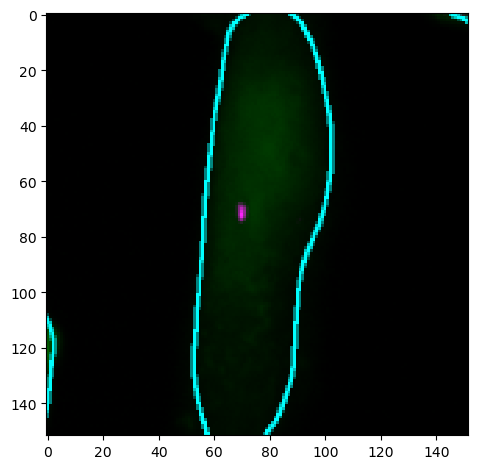

In [123]:
io.imshow(image[x_start:x_end,y_start:y_end])

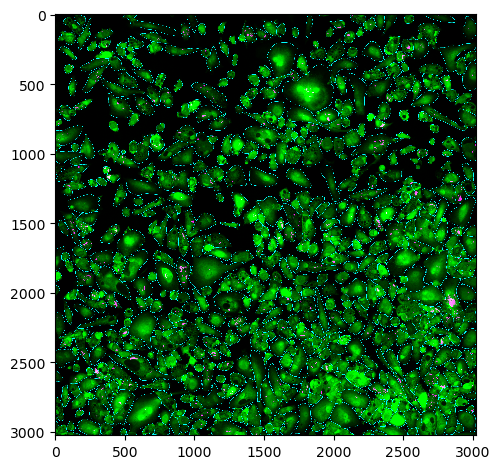

In [103]:
image = io.imread(subset_df.iloc[0]['image_url'])

# Display the image
io.imshow(image)
# io.show()


In [169]:
image.shape

(3024, 3024, 3)

In [208]:
subset_df.iloc[0]

Time_hours                                                                                       0
x                                                                                       723.909912
y                                                                                        33.010132
x_scaled                                                                               3648.505957
y_scaled                                                                                166.371064
Infection_status                                                                               1.0
Initial_infection_status                                                                       1.0
Final_infection_status                                                                         1.0
Area                                                                                       23203.0
Intracellular_mean_Mtb_content                                                          357.706421
Intracellu

In [165]:
width, height =500,500

In [187]:
size = np.sqrt(subset_df.iloc[0].Area)

In [212]:
for index, row_ in subset_df.iterrows():
    cell_ID = row_['Cell_ID']
    time = row_['Time_hours']
    glimpse_size = np.sqrt(row_.Area)#*1.2
    glimpse_x_html = max(0, int(row_.x_scaled/2) - glimpse_size/2)
    glimpse_y_html = max(0, int(row_.y_scaled/2) - glimpse_size/2)
    subset_df.at[index, 'glimpse_size'] = glimpse_size
    subset_df.at[index, 'glimpse_x_html'] = glimpse_x_html
    subset_df.at[index, 'glimpse_y_html'] = glimpse_y_html

In [209]:
subset_df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,...,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID,glimpse_size,glimpse_x_html,glimpse_y_html,image_url,color_codes
26058,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,CTRL,EC0,423,"(3, 5)",423.3.5,182.790372,1732.604814,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26059,1,727.771362,38.211437,3667.967666,192.585644,1.0,1.0,1.0,25659.0,363.283356,...,CTRL,EC0,423,"(3, 5)",423.3.5,192.221123,1736.889439,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26060,2,730.887634,26.283424,3683.673677,132.468459,1.0,1.0,1.0,19483.0,355.947845,...,CTRL,EC0,423,"(3, 5)",423.3.5,167.497821,1757.251090,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26061,3,732.147583,27.895367,3690.023818,140.592648,1.0,1.0,1.0,22840.0,354.730682,...,CTRL,EC0,423,"(3, 5)",423.3.5,181.354901,1754.322550,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26062,4,730.891357,33.019173,3683.692441,166.416630,1.0,1.0,1.0,23224.0,356.257538,...,CTRL,EC0,423,"(3, 5)",423.3.5,182.873071,1749.563465,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52067,70,492.403778,24.697016,2481.715042,124.472959,0.0,0.0,0.0,19249.0,362.092590,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,166.488919,1156.755541,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52068,71,499.927917,23.146204,2519.636704,116.656868,0.0,0.0,0.0,20651.0,362.858032,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,172.445470,1172.777265,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52069,72,488.879822,27.473850,2463.954302,138.468205,0.0,0.0,0.0,17785.0,362.595886,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,160.032497,1150.983752,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52070,73,503.570892,22.717241,2537.997297,114.494896,0.0,0.0,0.0,18913.0,364.106873,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,165.029452,1185.485274,0.0,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"


In [213]:
from IPython.display import display, HTML

for i in range(1340,1345):


    # URL of the image
    url = subset_df.iloc[i]['image_url']

    # Create the HTML code to display the image
    # image_html = f'<img src="{url}" alt="Image" style="margin: -{@y_end}px -{@x_start}px -{@y_start}px -{@x_end}px;"/>'
    # <img
    #                     src="@image_url" alt="@image_url"
    #     style="margin: -{@y_end}px -{@x_start}px -{@y_start}px -{@x_end}px;"
    #                     border="2"
    #                 />
    # Display the image
    # image_html = f'<img src="{url}" alt="Image" style="width: {width}px; height: {height}px; object-fit: none; object-position: -{int(subset_df.iloc[0].y_html-width)}px -{int(subset_df.iloc[0].x_html-height)}px;"/>'
    image_html = f'<img src="{url}" alt="Image" style="width: {subset_df.iloc[i].glimpse_size}px; height: {subset_df.iloc[i].glimpse_size}px; object-fit: none; object-position: -{subset_df.iloc[i].glimpse_x_html}px -{subset_df.iloc[i].glimpse_y_html}px;"/>'

    display(HTML(image_html))

### Filter df

In [28]:
subset_df = subset_df[(subset_df['Time_hours'] >= 0) & (subset_df['Time_hours'] <= 19)]

### Plot

In [223]:
source.data['Unique_ID']

array(['423.3.5', '423.3.5', '423.3.5', ..., '1783.3.5', '1783.3.5',
       '1783.3.5'], dtype=object)

In [222]:
source = ColumnDataSource(data=subset_df)


In [224]:
subset_df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,...,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID,glimpse_size,glimpse_x_html,glimpse_y_html,image_url,color_codes
26058,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,CTRL,EC0,423,"(3, 5)",423.3.5,152.325310,1747.837345,6.837345,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26059,1,727.771362,38.211437,3667.967666,192.585644,1.0,1.0,1.0,25659.0,363.283356,...,CTRL,EC0,423,"(3, 5)",423.3.5,160.184269,1752.907866,15.907866,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26060,2,730.887634,26.283424,3683.673677,132.468459,1.0,1.0,1.0,19483.0,355.947845,...,CTRL,EC0,423,"(3, 5)",423.3.5,139.581517,1771.209241,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26061,3,732.147583,27.895367,3690.023818,140.592648,1.0,1.0,1.0,22840.0,354.730682,...,CTRL,EC0,423,"(3, 5)",423.3.5,151.129084,1769.435458,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
26062,4,730.891357,33.019173,3683.692441,166.416630,1.0,1.0,1.0,23224.0,356.257538,...,CTRL,EC0,423,"(3, 5)",423.3.5,152.394226,1764.802887,6.802887,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(117, 179, 58)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52067,70,492.403778,24.697016,2481.715042,124.472959,0.0,0.0,0.0,19249.0,362.092590,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,138.740765,1170.629617,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52068,71,499.927917,23.146204,2519.636704,116.656868,0.0,0.0,0.0,20651.0,362.858032,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,143.704558,1187.147721,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52069,72,488.879822,27.473850,2463.954302,138.468205,0.0,0.0,0.0,17785.0,362.595886,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,133.360414,1164.319793,2.319793,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"
52070,73,503.570892,22.717241,2537.997297,114.494896,0.0,0.0,0.0,18913.0,364.106873,...,CTRL,EC0,1783,"(3, 5)",1783.3.5,137.524543,1199.237728,0.000000,https://macrohet.s3.eu-west-2.amazonaws.com/ti...,"(142, 1, 82)"


In [228]:
TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="title",
           plot_height = int(1080*0.5),
           tools = TOOLS, plot_width = int(1920*0.5))
p.toolbar.active_scroll = p.select_one(WheelZoomTool)
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Mtb'
# source = ColumnDataSource(data=subset_df)

p.scatter(source = ColumnDataSource(data=subset_df), 
         x='Time_hours', 
           y='Intracellular_thresholded_Mtb_content_smooth',)

# for ID in long_true_unique_IDs:
#     ID_df = subset_df[subset_df['Unique_ID']==ID]
#     cell_ID = ID_df['Cell_ID'].iloc[0]
#     color = ID_df["color_codes"].iloc[0]
# #     source = ColumnDataSource(data=ID_df) # here lies the issue... defining source as sc df
#     p.line(source=source,
#            x='Time_hours', 
#            y='Intracellular_thresholded_Mtb_content_smooth',
#            color=color, 
#            line_width = 3.5, 
#            alpha=0.8,
#            muted_color=color, 
#            muted_alpha=0.2, legend_label=f'Cell ID:{cell_ID}')

# p.select_one(HoverTool).tooltips = [
#     ('Time (hours)', '@x'),
#     ('Mtb', '@y'),
#     ('Cell ID', '@Cell_ID')
# ]

# Configure the hover tool for tooltips
hover = HoverTool(
    tooltips="""
        <div>
            <div style="width: 120px; height: 120px; overflow: hidden;">
                <img
                    src="@image_url" alt="@image_url"
                    style="width: {@glimpse_size}px; height: {@glimpse_size}px; object-fit: none; object-position: -{@glimpse_x_html}px -{@glimpse_y_html}px;"
                    border="2"
                />
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @Cell_ID</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">ΔMtb: @delta_Mtb_max_foldchange_normalised_max_area</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;"Mtb: @Intracellular_thresholded_Mtb_content_smooth</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Area: @Area</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Eccentricity: @Eccentricity</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Strain: @Strain</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Compound: @Compound</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Concentration: @Concentration</span>
            </div>
        </div>
    """
)

# Add the hover tool to the plot
p.add_tools(hover)


# for ID in long_true_unique_IDs:
#     ID_df = subset_df[subset_df['Unique_ID']==ID]
#     cell_ID = ID_df['Cell_ID'].iloc[0]
#     color = ID_df["color_codes"].iloc[0]
# #     source = ColumnDataSource(data=ID_df) # here lies the issue... defining source as sc df
#     p.line(source=ColumnDataSource(data=ID_df),
#            x='Time_hours', 
#            y='Intracellular_thresholded_Mtb_content_smooth',
#            color=color, 
#            line_width = 3.5, 
#            alpha=0.8,
#            muted_color=color, 
#            muted_alpha=0.2,)
# #     legend_label=f'Cell ID:{cell_ID}')


p.legend.location = "top_left"
p.legend.click_policy="mute"

output_file("mtb_time_series.html", title="Line Chart")
show(p)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/bokeh/models/plots.py:815: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/bokeh/models/plots.py:815: UserWarning: 
You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [69]:
y_coord, x_coord, area = subset_df.loc[(subset_df['Cell_ID'] == cell_ID) & (subset_df['Time_hours'] == time), ['x', 'y', 'Area']].iloc[0]

In [75]:
subset_df.loc[(subset_df['Cell_ID'] == cell_ID) & (subset_df['Time_hours'] == time), ['x', 'y', 'Area']].iloc[0]

x       391.115387
y         9.405981
Area           NaN
Name: 26267, dtype: float64

In [70]:
y_coord

723.909912109375

In [104]:
def crop_bounding_box(cell_ID, time, df, crop_size=None, track_scale_factor=5.04, 
                      image_shape = (6048,6048), image_scale_factor=2):
    # Extract xy coordinates and transpose for python and area from the cell information
    y_coord, x_coord, area = df.loc[(df['Cell_ID'] == cell_ID) & (df['Time_hours'] == time), ['x_scaled', 'y_scaled', 'Area']].iloc[0]
    
    # Scale according to tracking shrinkage
#     y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor
    
    if not crop_size:
        # Calculate the side length for cropping based on the square root of the area
        side_length = int(np.sqrt(area)) * 2
    
    # Calculate the cropping boundaries
    x_start = int(x_coord - side_length/2)
    x_end = int(x_coord + side_length/2)
    y_start = int(y_coord - side_length/2)
    y_end = int(y_coord + side_length/2)
    
    # Pad the boundaries if they exceed the image dimensions
    if x_start < 0:
        x_pad = abs(x_start)
        x_start = 0
    else:
        x_pad = 0
    
    if x_end > image_shape[0]:
        x_pad_end = x_end - image_shape[0]
        x_end = image_shape[0]
    else:
        x_pad_end = 0
    
    if y_start < 0:
        y_pad = abs(y_start)
        y_start = 0
    else:
        y_pad = 0
    
    if y_end > image_shape[1]:
        y_pad_end = y_end - image_shape[1]
        y_end = image_shape[1]
    else:
        y_pad_end = 0
    
    x_start, x_end, y_start, y_end = int(x_start/image_scale_factor), int(x_end/image_scale_factor), int(y_start/image_scale_factor), int(y_end/image_scale_factor)
    
    return x_start, x_end, y_start, y_end

# WIP plots

In [138]:
"""
This plot can be edited to show the different conditions and hide them upon clicking
"""

TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="title",
           plot_height = int(1080*0.75),
           tools = TOOLS, plot_width = int(1920*0.75))
p.toolbar.active_scroll = p.select_one(WheelZoomTool)
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Mtb'

for ID in long_true_unique_IDs:
    ID_df = subset_df[subset_df['Unique_ID']==ID]
    cell_ID = ID_df['Cell_ID'].iloc[0]
    color = ID_df["color_codes"].iloc[0]
    source = ColumnDataSource(data=ID_df)
    p.line(source=source,
           x='Time_hours', 
           y='Intracellular_thresholded_Mtb_content_smooth',
           color=color, 
           line_width = 3.5, 
           alpha=0.8,
           muted_color=color, 
           muted_alpha=0.2, legend_label=f'Cell ID:{cell_ID}')

p.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@Cell_ID')
]

p.legend.location = "top_left"
p.legend.click_policy="mute"

output_file("mtb_time_series.html", title="Line Chart")
show(p)